<a href="https://colab.research.google.com/github/dan-a-iancu/Data-Analytics-and-AI/blob/master/Pricing_Bottlenecks_and_Flexibility/Analytics_at_Prosche_Motors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements the solution to the **Alset Motors** mini-case. It assumes you are familiar with the case and the model.

In [ ]:
#@markdown Import useful modules and initial setup.

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# import numpy
import numpy as np
import urllib.request  # for file downloading

# Import pandas for data-frames
import pandas as pd
pd.options.display.max_rows = 15
pd.options.display.float_format = "{:,.2f}".format

from IPython.display import display

# Make sure Matplotlib runs inline, for nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import matplotlib.ticker as ticker

# install Gurobi (our linear optimization solver)
#!pip install -i https://pypi.gurobi.com gurobipy
from gurobipy import *

# install the latest version of seaborn for nicer graphics
#!pip install --prefix {sys.prefix} seaborn==0.11.0  &> /dev/null
import seaborn as sns

# Ignore useless some warnings
import warnings
warnings.simplefilter(action="ignore")

print("Completed successfully!")

########################
# Download the entire data as an Excel file from Github

url_Excel = 'https://raw.githubusercontent.com/dan-a-iancu/OIT248/master/Prosche_Motors/Prosche_Motors_Data.xlsx?raw=true'
local_file = "Prosche_Motors_Data.xlsx"   # name of local file where you want to store the downloaded file
urllib.request.urlretrieve(url_Excel, local_file)    # download from website and save it locally

########################
# SET UP DATAFRAMES
factoriesDF = pd.read_excel("Prosche_Motors_Data.xlsx", sheet_name = "Factories", index_col=0)
costsFactoriesToCentersDF = pd.read_excel("Prosche_Motors_Data.xlsx", \
                                    sheet_name = "Factories_to_Centers", index_col=0)
customizationCentersDF = pd.read_excel("Prosche_Motors_Data.xlsx", sheet_name = "Customization_Centers", index_col=0)
retailersDF = pd.read_excel("Prosche_Motors_Data.xlsx", sheet_name = "Retailer_Preorders", index_col=0)
costsCentersToRetailersDF = pd.read_excel("Prosche_Motors_Data.xlsx", \
                              sheet_name = "Centers_to_Retailers", index_col=0)

# Create useful lists with the factories, centers, clients
# Calculate some useful lists: the factories, the customization centers, the clients
factories = list( factoriesDF.index )              # the list of factories
centers = list( customizationCentersDF.index )     # the list of customization centers
retailers = list( retailersDF.index )              # the list of retailers

########################
# USEFUL FUNCTIONS
# A function that generates and returns a model like the one in **Q1**
def create_model_like_in_Q1(use_custom_demands=False, custom_demand_dict={}):
    # empty Gurobi model
    m = Model("Prosche Motors Supply Chain Model")

    # Decision variables
    # decision variables for how much to ship from each factory to each customization center
    factoriesToCenters = m.addVars( factories, centers , name = "Ship")

    # decision variables for how much to ship from each customization center to each client
    centersToRetailers = m.addVars( centers, retailers , name="Ship")

    # Objective
    ### REVENUES

    # calculate how much each retailer receives
    retailerReceipts = {}
    for r in retailers:
        retailerReceipts[r] = quicksum( centersToRetailers[c,r] for c in centers )

    # calculate revenues
    revenues = quicksum( retailerReceipts[r] * retailersDF.loc[r,"Price"] for r in retailers )

    ### COSTS
    # there are four terms:
    # - production costs (at factories)
    prodCost = quicksum( factoriesToCenters[f,c] * factoriesDF.loc[f,"Cost"]\
                        for f in factories for c in centers )

    # - handling & transportation costs factories to customization centers
    transCost_FC = quicksum( factoriesToCenters[f,c] * \
                            costsFactoriesToCentersDF.loc[f,c] for f in factories for c in centers )

    # - customization cost (incurred at the customization centers)
    customizationCost = quicksum( centersToRetailers[c,r] * \
                                 customizationCentersDF.loc[c,"Staffing_Cost"] \
                                 for c in centers for r in retailers )

    # - transportation costs customization centers to retail stores
    transCost_CR = quicksum( centersToRetailers[c,r] * \
                            costsCentersToRetailersDF.loc[c,r] for c in centers for r in retailers )

    # total costs
    totalCost =  prodCost + transCost_FC + customizationCost + transCost_CR     # total cost is the sum

    # gross profit
    gross_profit = revenues - totalCost

    # set the objective: maximize gross profit
    m.setObjective( gross_profit, GRB.MAXIMIZE )

    # Constraints
    constraints = {}  # will store all the constraints

    # capacity constraints due to production at each factory
    constraints["factory_cap"] = {}
    for f in factories :
        constraints["factory_cap"][f] = \
        m.addConstr( quicksum(factoriesToCenters[f,c] for c in centers) \
                    <= factoriesDF.loc[f,"Capacity"], name = "Cap_" + f)

    # capacity constraints at customization centers
    constraints["center_cap"] = {}
    for c in centers :
        constraints["center_cap"][c] = \
        m.addConstr( quicksum(centersToRetailers[c,r] for r in retailers) \
                    <= customizationCentersDF.loc[c,"Capacity"], name = "Cap_" + c)

    # flow conservation at each customization center: cars going in = cars going out
    for c in centers :
        m.addConstr( quicksum(factoriesToCenters[f,c] for f in factories) == \
                            quicksum(centersToRetailers[c,r] for r in retailers), name = "Flow_cons_" + c )

    # cannot ship more than pre-orders at each store
    constraints["sales_cap"] = {}
    if use_custom_demands:
        # using custom demands, specified in a dictionary
        for r in retailers :
            constraints["sales_cap"][r] = \
            m.addConstr( retailerReceipts[r] <= custom_demand_dict[r], name = "Demand_" + r)

    else:
        # using the default pre-orders in the case
        for r in retailers :
            constraints["sales_cap"][r] = \
            m.addConstr( retailerReceipts[r] <= retailersDF.loc[r,"Pre-orders"], name = "Preorder_" + r)

    # return the model, the decision variables and the formula for the objective
    return m, factoriesToCenters, centersToRetailers, retailerReceipts, gross_profit,\
    constraints

########################
# A function that calculates the gross profit for a given shipment plan specified with Gurobi variables
# - to compare this gross profit to Q1, set 'compare_to_Q1 = True'
# - to also calculate and print information about the solution, set 'interpret_solution = True'
def calculate_profit_and_compare_Q1(factoriesToCenters, centersToRetailers, retailerReceipts, \
                                    compare_to_Q1, interpret_solution):
    # revenues
    revenue = sum( centersToRetailers[c,r].X * retailersDF.loc[r,"Price"] \
                      for c in centers for r in retailers )

    # - production costs (at factories)
    prodCost = sum( factoriesToCenters[f,c].X * factoriesDF.loc[f,"Cost"] \
                       for f in factories for c in centers )

    # - handling & transportation costs factories to customization centers
    transCost_FC = sum( factoriesToCenters[f,c].X * costsFactoriesToCentersDF.loc[f,c] \
                            for f in factories for c in centers )

    # - customization cost (incurred at the customization centers)
    customizationCost = sum( centersToRetailers[c,r].X * customizationCentersDF.loc[c,"Staffing_Cost"] \
                            for c in centers for r in retailers )

    # - transportation costs customization centers to retail stores
    transCost_CR = sum( centersToRetailers[c,r].X * costsCentersToRetailersDF.loc[c,r] \
                       for c in centers for r in retailers )

    # gross profit
    profit =  revenue - (prodCost + transCost_FC + customizationCost + transCost_CR)

    # print
    print(f"Gross profit: {profit:,.0f}.")
    if (compare_to_Q1):
        print(f"Profit change compared to Q1: {(profit/gross_profit_Q1-1.0)*100:.0f}%.")

    # interpret the solution if desired
    if interpret_solution :
        print('{:<50}\nProduction at factories:'.format("="*50))
        for f in factories:
            print("   {:<6} : {:,.0f}".format(f, sum(factoriesToCenters[f,c].X for c in centers)) )

        # shipping factories to centers
        print("{:<50s}\nShipping from factories to customization centers:".format("="*50))
        for f in factories :
            for c in centers :
                print("   {:<5s} to {:<3s} : {:,.0f}".format(f,c,factoriesToCenters[f,c].X))

        # processing at customization centers
        print("{:<50s}\nProcessing at customization centers:".format("="*50))
        for c in centers:
            print("   {:<2s} : {:,.0f} ".format(c,sum( centersToRetailers[c,r].X for r in retailers)) )

        # shipping from centers to retailers
        print("{:<50s}\nShipping from customization centers:".format("="*50))
        for c in centers :
            for r in retailers :
                print("   {:<2s} to {:<2s} : {:,.0f}".format(c,r,centersToRetailers[c,r].X))

        # pre-orders fulfilled at each retailer
        print("{:<50}\nFilled orders and fill rates at retailers/clients:".format("="*50))
        for r in retailers:
            print("   {:<2s} : {:<5,.0f} orders filled, i.e., fill rate of {:<4,.1f} %."\
                  .format(r,retailerReceipts[r].getValue(),\
                          retailerReceipts[r].getValue()/retailersDF.loc[r,"Pre-orders"]*100))

Completed successfully!


_____
# **Q1**

##  Create an empty model

In [ ]:
#@markdown Create a model like the one in Q1 using the function
m_Q1, factoriesToCenters_Q1, centersToRetailers_Q1, retailerReceipts_Q1, gross_profit_Q1, constr_Q1 = \
       create_model_like_in_Q1()

run_silently = True

if run_silently:
    m_Q1.setParam('OutputFlag',0)
else:
    m_Q1.setParam('OutputFlag',1)

m_Q1.optimize()
print('\nSolved the optimization problem...')

calculate_profit_and_compare_Q1(factoriesToCenters_Q1, centersToRetailers_Q1, retailerReceipts_Q1, \
                                compare_to_Q1=False, interpret_solution=True)

gross_profit_Q1 = m_Q1.objVal


Solved the optimization problem...
Gross profit: 33,625,000.
Production at factories:
   Zuffe  : 5,000
   Leip   : 0
Shipping from factories to customization centers:
   Zuffe to C1  : 2,000
   Zuffe to C2  : 2,200
   Zuffe to C3  : 800
   Leip  to C1  : 0
   Leip  to C2  : 0
   Leip  to C3  : 0
Processing at customization centers:
   C1 : 2,000 
   C2 : 2,200 
   C3 : 800 
Shipping from customization centers:
   C1 to OO : 1,700
   C1 to FL : 300
   C1 to SH : 0
   C1 to WW : 0
   C2 to OO : 0
   C2 to FL : 2,200
   C2 to SH : 0
   C2 to WW : 0
   C3 to OO : 250
   C3 to FL : 0
   C3 to SH : 0
   C3 to WW : 550
Filled orders and fill rates at retailers/clients:
   OO : 1,950 orders filled, i.e., fill rate of 39.0 %.
   FL : 2,500 orders filled, i.e., fill rate of 100.0 %.
   SH : 0     orders filled, i.e., fill rate of 0.0  %.
   WW : 550   orders filled, i.e., fill rate of 100.0 %.


______
# **Q5-a**
Before running this section, make sure you have run all the previous sections of the Colab file.

The model here requires that the **fill rates** at distinct retailers do not differ too much. (Recall that the fill rate is defined as the ratio of filled orders divided by demand/preorders.)

Specifically, if $F[r]$ denotes the fill rate at retailer $r$ , we are imposing the constraints:<br>
> $ F[r_1] - F[r_2] \leq \Delta$, for every possible pair $r_1,r_2$,

where $\Delta$ is some pre-specified value for the maximum allowed difference.

In [ ]:
#@markdown Select the maximum allowed difference in fill rates (as a percentage)
max_difference_fill_rates = 0 #@param {type:"number"}
max_difference_fill_rates = max_difference_fill_rates/100

#markdown Create a model like the one in Q1
AlsetModel, factoriesToCenters, centersToRetailers, retailerReceipts, gross_profit, constr = \
       create_model_like_in_Q1()

# #@markdown Constrain the fill rate at each retailer
for r1 in retailers:
   for r2 in retailers:
      AlsetModel.addConstr(
          quicksum( centersToRetailers[c,r1] for c in centers )/retailersDF["Pre-orders"][r1] - \
          quicksum( centersToRetailers[c,r2] for c in centers )/retailersDF["Pre-orders"][r2] <= \
          max_difference_fill_rates )

# #@markdown Solve the new model
#@markdown Select whether to run the [Gurobi](https://www.gurobi.com/) optimization algorithms silently (no output details)
run_silently = True #@param {type:"boolean"}

if run_silently:
    AlsetModel.setParam('OutputFlag',0)
else:
    AlsetModel.setParam('OutputFlag',1)

AlsetModel.optimize()
print('\nSolved the optimization problem...\n')

if AlsetModel.status in [GRB.INFEASIBLE, GRB.INF_OR_UNBD]:
    # the model is infeasible
    print("It is infeasible to achieve this fill rate at all retailers.")

elif AlsetModel.status==GRB.OPTIMAL:
    # the model was solved to optimality
    # #@markdown Print the gross profit and the difference from Q1
    calculate_profit_and_compare_Q1(factoriesToCenters_Q1, centersToRetailers_Q1, retailerReceipts_Q1, \
                                    compare_to_Q1=True, interpret_solution=True)



Solved the optimization problem...

Gross profit: 33,625,000.
Profit change compared to Q1: 0%.
Production at factories:
   Zuffe  : 5,000
   Leip   : 0
Shipping from factories to customization centers:
   Zuffe to C1  : 2,000
   Zuffe to C2  : 2,200
   Zuffe to C3  : 800
   Leip  to C1  : 0
   Leip  to C2  : 0
   Leip  to C3  : 0
Processing at customization centers:
   C1 : 2,000 
   C2 : 2,200 
   C3 : 800 
Shipping from customization centers:
   C1 to OO : 1,700
   C1 to FL : 300
   C1 to SH : 0
   C1 to WW : 0
   C2 to OO : 0
   C2 to FL : 2,200
   C2 to SH : 0
   C2 to WW : 0
   C3 to OO : 250
   C3 to FL : 0
   C3 to SH : 0
   C3 to WW : 550
Filled orders and fill rates at retailers/clients:
   OO : 1,950 orders filled, i.e., fill rate of 39.0 %.
   FL : 2,500 orders filled, i.e., fill rate of 100.0 %.
   SH : 0     orders filled, i.e., fill rate of 0.0  %.
   WW : 550   orders filled, i.e., fill rate of 100.0 %.


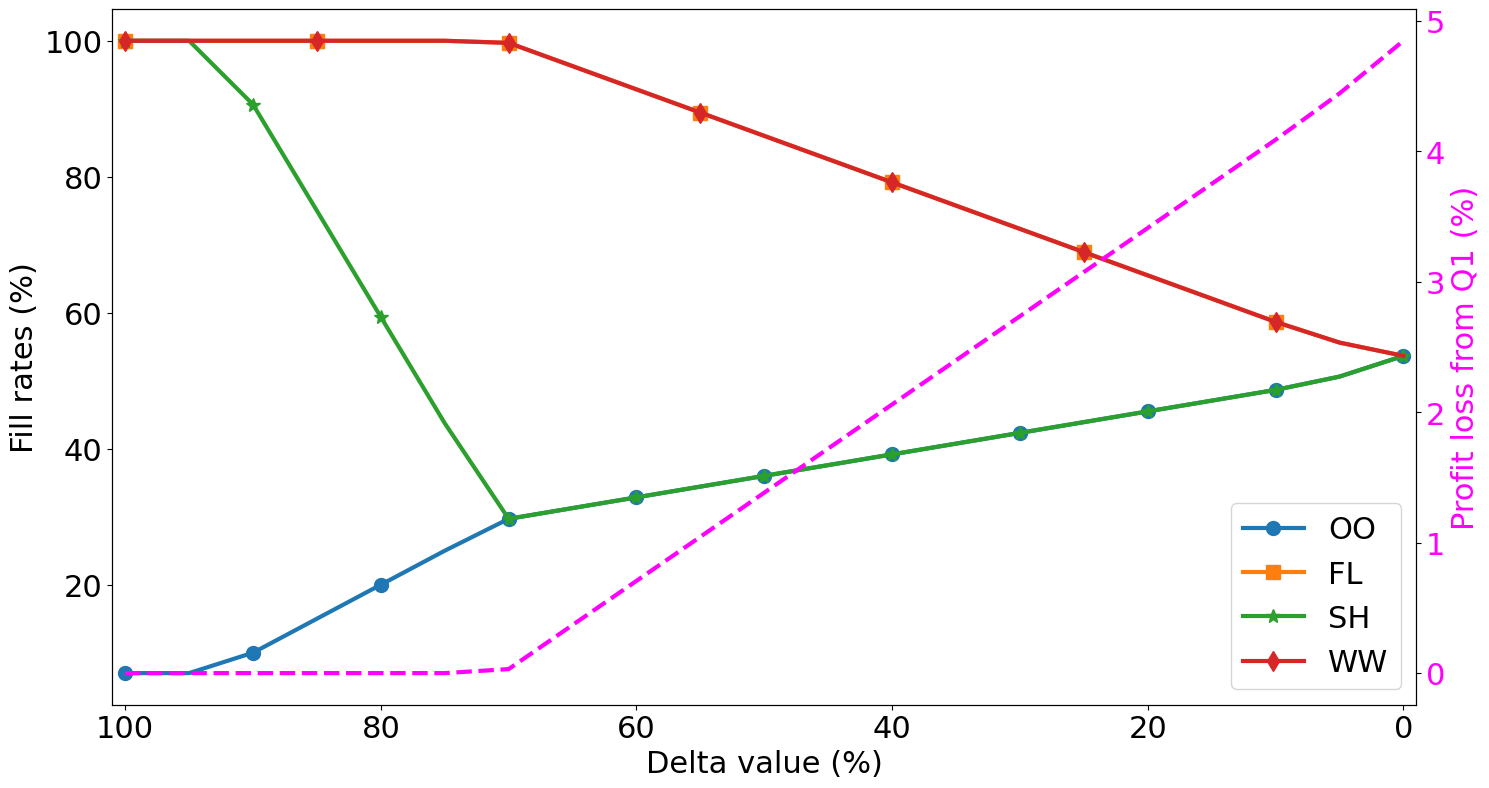

In [ ]:
#@markdown Double-click to show the code...
# set up values for the differente in fill rates (in %)
delta_vals = list(np.arange(100,-5,-5))

# the objective values and the loss compared to Q1
objValues = [0]*len(delta_vals)
loss_Q1 = [0]*len(delta_vals)

# a dictionary with a list for each customer, that stores the realized fill rate at that customer
individual_fillrates = {}
for r in retailers:
    individual_fillrates[r] = [0]*len(delta_vals)

for i in range(len(delta_vals)):

    # create new model from scratch
    model, factoriesToCenters, centersToRetailers, gross_profit, constr = \
          create_model_like_in_Q1()

    model.setParam('OutputFlag',0)

    # change the fill rate constraint
    for r1 in retailers:
      for r2 in retailers:
          model.addConstr(
              quicksum( centersToRetailers[c,r1] for c in centers )/retailersDF.loc[r1,"Pre-orders"] - \
              quicksum( centersToRetailers[c,r2] for c in centers )/retailersDF.loc[r2,"Pre-orders"] <= \
              delta_vals[i]/100 )

    model.optimize()
    objValues[i] = model.objVal
    loss_Q1[i] = (1.0 - objValues[i]/gross_profit_Q1)*100
    for r in retailers:
        individual_fillrates[r][i] = (sum(centersToRetailers[c,r].X for c in centers) / retailersDF.loc[r,"Pre-orders"])*100

# first settings are good for Powerpoint plots; second set is good in Colab
fontsize = 22
fig, ax1 = plt.subplots(figsize=(15,8))
markersize = 10
linewidth = 3
#fontsize = 12
#fig, ax1 = plt.subplots(figsize=(10,5))
#markersize = 5
#linewidth = 2
color1 = 'black'

# plot only a few markers for each plot (that way one can disambiguate)
markevery = [2, 3, 2, 3]
markers = ['o', 's', '*', 'd']

for i in range(len(retailers)):
    plt.plot(delta_vals, individual_fillrates[retailers[i]], linestyle='solid', \
             linewidth=linewidth,marker=markers[i],\
             markersize=markersize, markevery=markevery[i])

plt.xlabel("Delta value (%)", fontsize=fontsize)
plt.ylabel("Fill rates (%)", color=color1, fontsize=fontsize)
ax1.tick_params(axis='y', labelcolor=color1)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
ax1.legend(retailers, fontsize=fontsize, loc="lower right")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color2 = 'magenta'
ax2.set_ylabel('Profit loss from Q1 (%)', color=color2, fontsize=fontsize)  # we already handled the x-label with ax1
ax2.plot(delta_vals, loss_Q1, color='magenta', linestyle='--', linewidth=linewidth)
ax2.tick_params(axis='y', labelcolor=color2)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)

plt.xlim(max(delta_vals)+1, min(delta_vals)-1)

plt.tight_layout()
plt.show()

______
# **Q5-b**
Before running this section, make sure you have run all the previous sections of the Colab file.

This model requires that the **fill rate** for each retailer is at least as large as some pre-specified lower bound. (Recall that the fill rate is defined as the ratio of filled orders divided by demand/preorders.)

That is, if $F[r]$ denotes the fill rate achieved at retailer $r$, we are imposing the constraints:<br>
> $ F[r] \geq f$ for every retailer $r$

where $f$ is the minimum required fill-rate (a value between 0 and 1).

In [ ]:
#@title Solve a single problem instance with a minimum fill rate requirement
#@markdown Select the desired minimum fill rate (as a percentage)
min_fill_rate = 72.5 #@param {type:"number"}
min_fill_rate = min_fill_rate/100

#markdown Create a model like the one in Q1
m_Q5, factoriesToCenters_Q5, centersToRetailers_Q5, retailerReceipts_Q5, gross_profit_Q5, constr_Q5 = \
       create_model_like_in_Q1()

# Constrain the fill rate at each retailer
fill_rate_constraint = {}  # store the fill rate constraints in a dictionary, to make it easy to recall them
for r in retailers :
    fill_rate_constraint[r] = \
    m_Q5.addConstr( retailerReceipts_Q5[r] / retailersDF["Pre-orders"][r] >= min_fill_rate)

# Solve the new model
#@markdown Select whether to run the [Gurobi](https://www.gurobi.com/) optimization algorithms silently (no output details)
run_silently = True #@param {type:"boolean"}

if run_silently:
    m_Q5.setParam('OutputFlag',0)
else:
    m_Q5.setParam('OutputFlag',1)

m_Q5.optimize()
print('\nSolved the optimization problem...\n')

if m_Q5.status in [GRB.INFEASIBLE, GRB.INF_OR_UNBD]:
    # the model is infeasible
    print("It is infeasible to achieve this fill rate at all retailers.")

elif m_Q5.status==GRB.OPTIMAL:
    # the model was solved to optimality
    # Print the gross profit and the difference from Q1
    calculate_profit_and_compare_Q1(factoriesToCenters_Q5, centersToRetailers_Q5, retailerReceipts_Q5, \
                                    compare_to_Q1=True, interpret_solution=True)


Solved the optimization problem...

Gross profit: 31,716,250.
Profit change compared to Q1: -6%.
Production at factories:
   Zuffe  : 5,000
   Leip   : 2,000
Shipping from factories to customization centers:
   Zuffe to C1  : 2,000
   Zuffe to C2  : 200
   Zuffe to C3  : 2,800
   Leip  to C1  : 0
   Leip  to C2  : 2,000
   Leip  to C3  : 0
Processing at customization centers:
   C1 : 2,000 
   C2 : 2,200 
   C3 : 2,800 
Shipping from customization centers:
   C1 to OO : 1,228
   C1 to FL : 772
   C1 to SH : 0
   C1 to WW : 0
   C2 to OO : 0
   C2 to FL : 1,040
   C2 to SH : 1,160
   C2 to WW : 0
   C3 to OO : 2,397
   C3 to FL : 0
   C3 to SH : 0
   C3 to WW : 403
Filled orders and fill rates at retailers/clients:
   OO : 3,625 orders filled, i.e., fill rate of 72.5 %.
   FL : 1,812 orders filled, i.e., fill rate of 72.5 %.
   SH : 1,160 orders filled, i.e., fill rate of 72.5 %.
   WW : 403   orders filled, i.e., fill rate of 73.2 %.


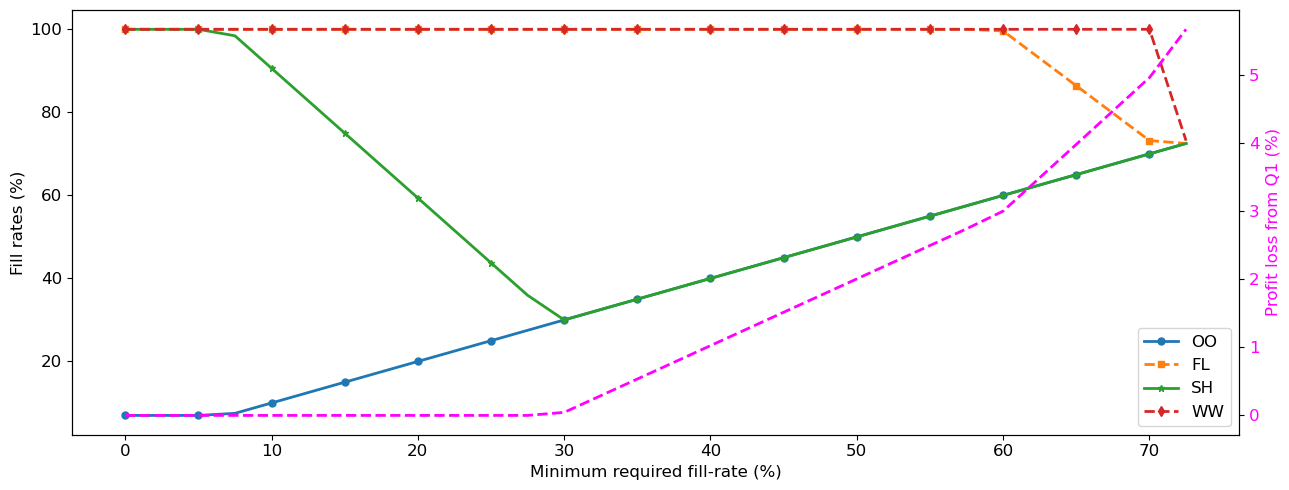

In [ ]:
#@title Examine how the gross profit losses and the achieved fill rates depend on the minimum fill rate requirement
fill_rate_vals = list(np.arange(0,75.0,2.5))      # set up values for the fill rate (in percentage terms)

# the objective values and the loss compared to Q1
objValues = [0]*len(fill_rate_vals)
loss_Q1 = [0]*len(fill_rate_vals)

# a dictionary with a list for each customer, that stores the realized fill rate at that customer
individual_fillrates = {}
for r in retailers:
    individual_fillrates[r] = [0]*len(fill_rate_vals)

for i in range(len(fill_rate_vals)):
    # change the fill rate constraint
    for r in retailers :
        fill_rate_constraint[r].setAttr('rhs', fill_rate_vals[i]/100)

    m_Q5.optimize()
    objValues[i] = m_Q5.objVal
    loss_Q1[i] = (1.0 - objValues[i]/gross_profit_Q1)*100
    for r in retailers:
        individual_fillrates[r][i] = retailerReceipts_Q5[r].getValue() / retailersDF["Pre-orders"][r]*100

#@markdown Do a single plot for everything
#fontsize = 30
#fig, ax1 = plt.subplots(figsize=(15,8))
#markersize = 10
#linewidth = 3
fontsize = 12
fig, ax1 = plt.subplots(figsize=(13,5))
markersize = 5
linewidth = 2

color1 = 'black'

# plot only a few markers for each plot (that way one can disambiguate)
linestyle = ["solid", "dashed", "solid", "dashed"]
markevery = [2, 2, 2, 2]
markers = ['o', 's', '*', 'd']

for i in range(len(retailers)):
    plt.plot(fill_rate_vals, individual_fillrates[retailers[i]], \
             linestyle=linestyle[i], \
             linewidth=linewidth, marker=markers[i], markersize=markersize, \
             markevery=markevery[i])

plt.xlabel("Minimum required fill-rate (%)", fontsize=fontsize)
plt.ylabel("Fill rates (%)", color=color1, fontsize=fontsize)
ax1.tick_params(axis='y', labelcolor=color1)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.legend(retailers, fontsize=fontsize)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color2 = 'magenta'
ax2.set_ylabel('Profit loss from Q1 (%)', color=color2, fontsize=fontsize)  # we already handled the x-label with ax1
ax2.plot(fill_rate_vals, loss_Q1, color='magenta', linestyle='--', linewidth=linewidth)
ax2.tick_params(axis='y', labelcolor=color2)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)

plt.tight_layout()
plt.show()

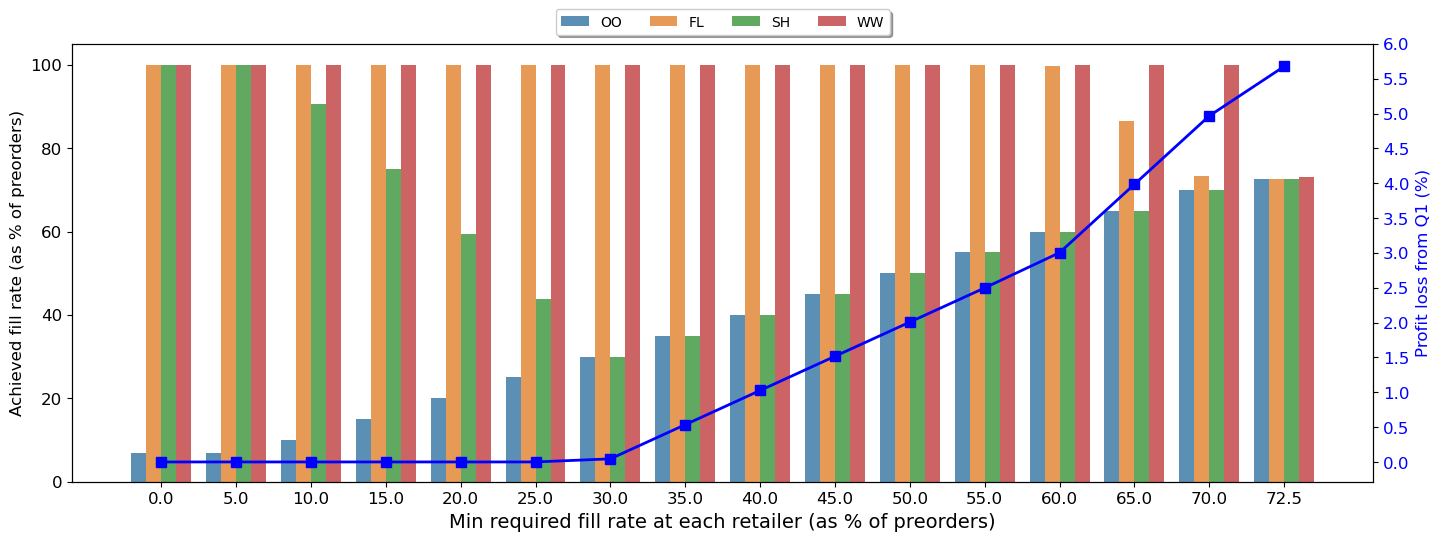

In [ ]:
#@title Examine how the gross profit losses and the achieved fill rates depend on the minimum fill rate requirement
inc = 5.0
fill_rate_vals = list(np.arange(0,70+inc,inc)) + [72.5]      # set up values for the fill rate (in percentage terms)

# the objective values and the loss compared to Q1
objValues = [0]*len(fill_rate_vals)
loss_Q1 = [0]*len(fill_rate_vals)

# a dictionary with a list for each customer, that stores the realized fill rate at that customer
individual_fillrates = {}
for r in retailers:
    individual_fillrates[r] = [0]*len(fill_rate_vals)

for i in range(len(fill_rate_vals)):
    # change the fill rate constraint
    for r in retailers :
        fill_rate_constraint[r].setAttr('rhs', fill_rate_vals[i]/100)

    AlsetModel.optimize()
    objValues[i] = AlsetModel.objVal
    loss_Q1[i] = (1.0 - objValues[i]/gross_profit_Q1)*100
    for r in retailers:
        individual_fillrates[r][i] = (sum(centersToRetailers[c,r].X for c in centers) / retailersDF["Pre-orders"][r])*100

# create a dataframe with the values of fill rates
df = pd.DataFrame(individual_fillrates, index=fill_rate_vals)

# Reset index to keep the x_values in a column
df = df.reset_index().melt(id_vars=['index'], var_name='Retailer', \
                           value_name='Fill_Rate')

# Rename the 'index' column to a more meaningful name, if desired
df.rename(columns={'index': 'Perc_Diff'}, inplace=True)

fontsize = 12

fig_width = 14.5
fig_height = 5.0

fig = plt.figure(figsize=(fig_width, 2 * fig_height))

plt.subplot(2,1,1)
color1 = 'black'
ax1 = plt.gca()
sns.barplot(data=df, x='Perc_Diff', y='Fill_Rate', \
            #order=["OO", "FL", "WW", "SH"], \
            hue="Retailer", \
            alpha=0.8, zorder=1)
plt.legend(loc='center', bbox_to_anchor=(0.5, 1.05), \
           fancybox=True, shadow=True, ncol=4)
ax1.set_ylabel('Achieved fill rate (as % of preorders)', \
           color=color1, fontsize=fontsize)  # we already handled the x-label with ax1
ax1.set_xlabel("Min required fill rate at each retailer (as % of preorders)")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color2 = 'blue'
ax2.set_ylabel('Profit loss from Q1 (%)', color=color2, fontsize=fontsize)  # we already handled the x-label with ax1
ax2.plot(loss_Q1, color=color2, linestyle='-', linewidth=linewidth, \
         marker='s', markersize=7.0)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_yticks(np.arange(0,6.25,0.5))
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)

# plt.subplot(2,1,2)
# ax2 = plt.gca()
# color2 = 'magenta'
# ax2.set_ylabel('Profit loss from Q1 (%)', color=color2, fontsize=fontsize)  # we already handled the x-label with ax1
# ax2.plot(fill_rate_vals, loss_Q1, color='magenta', linestyle='--', linewidth=linewidth)
# ax2.tick_params(axis='y', labelcolor=color2)
# plt.yticks(fontsize=fontsize)
# plt.xticks(fontsize=fontsize)

plt.tight_layout()
plt.show()

______
# **Q6**
Before running this section, make sure you have run all the previous sections of the Colab file.

Here, we change the capacity in each facility (one at a time), resolve the problem, and record the difference in gross profits compared to **Q1**.

In [ ]:
#@title Increase capacity **in each facility at a time** by some amount:

capacity_increase = 1 #@param {type:"number"}

for facility in ["Zuffe", "Leip", "C1", "C2", "C3"]:
    #markdown Create a model like the one in Q1
    m_Q6, factoriesToCenters, centersToRetailers, retailerReceipts, gross_profit, constr = \
          create_model_like_in_Q1()

    if facility in factories:
        constr["factory_cap"][facility].setAttr('rhs', factoriesDF["Capacity"][facility] + capacity_increase)

    elif facility in centers:
        constr["center_cap"][facility].setAttr('rhs', customizationCentersDF["Capacity"][facility] + capacity_increase)

    # run Gurobi silently
    m_Q6.setParam('OutputFlag',0)
    m_Q6.optimize()

    if m_Q6.status in [GRB.INFEASIBLE, GRB.INF_OR_UNBD]:
        # the model is infeasible
        print("The model is infeasible.")

    elif m_Q6.status==GRB.OPTIMAL:
        # the model was solved to optimality
        print("By increasing the capacity at {} by {} unit(s), the profit difference compared to Q1 is: {:,.2f}".\
              format(facility, capacity_increase, m_Q6.objVal - gross_profit_Q1))

By increasing the capacity at Zuffe by 1 unit(s), the profit difference compared to Q1 is: 3,000.00
By increasing the capacity at Leip by 1 unit(s), the profit difference compared to Q1 is: 0.00
By increasing the capacity at C1 by 1 unit(s), the profit difference compared to Q1 is: 6,000.00
By increasing the capacity at C2 by 1 unit(s), the profit difference compared to Q1 is: 1,500.00
By increasing the capacity at C3 by 1 unit(s), the profit difference compared to Q1 is: 0.00


In [ ]:
# create and solve an identical model to Q1
model, factoriesToCenters, centersToRetailers, retailerReceipts, gross_profit, constr = \
          create_model_like_in_Q1()

# run Gurobi silently
model.setParam('OutputFlag',0)
model.optimize()

# display information on all the constraints
allConstraints = model.getConstrs()

all_constr_data = [ [c.ConstrName, model.getRow(c).getValue(), c.Sense, c.RHS, c.Slack, \
                     c.Pi, c.SARHSLow, c.SARHSUp ] for c in allConstraints ]

# convert into a dataframe and print
df = pd.DataFrame(all_constr_data, columns=["Constraint Name", "LHS Value", "Sense", "RHS Value", "Slack", "Shadow Price",\
                                           "Lower Limit RHS", "Upper Limit RHS"])
display(df)

,Constraint Name,LHS Value,Sense,RHS Value,Slack,Shadow Price,Lower Limit RHS,Upper Limit RHS
0,Cap_Zuffe,"5,000.00",<,"5,000.00",0.00,"3,000.00","4,750.00","7,500.00"
1,Cap_Leip,0.00,<,"2,000.00","2,000.00",0.00,0.00,inf
2,Cap_C1,"2,000.00",<,"2,000.00",0.00,"6,000.00",300.00,"2,250.00"
3,Cap_C2,"2,200.00",<,"2,200.00",0.00,"1,500.00",500.00,"2,450.00"
4,Cap_C3,800.00,<,"3,300.00","2,500.00",0.00,800.00,inf
5,Flow_cons_C1,0.00,=,0.00,0.00,"-58,000.00","-2,000.00",250.00
6,Flow_cons_C2,0.00,=,0.00,0.00,"-59,500.00","-2,200.00",250.00
7,Flow_cons_C3,0.00,=,0.00,0.00,"-59,000.00","-2,500.00",250.00
8,Preorder_OO,"1,950.00",<,"5,000.00","3,050.00",0.00,"1,950.00",inf
9,Preorder_FL,"2,500.00",<,"2,500.00",0.00,"1,000.00","2,200.00","4,200.00"


In [ ]:
#@title The code below allows you to calculate how the profit changes as a function of the capacity increase

#@markdown Select one of the facilities
facility = 'C1' #@param ["Zuffe", "Leip", "C1", "C2", "C3"] {allow-input: false}

#@markdown Select by how much to change the capacity at the facility (positive or negative changes allowed)
capacity_change = 1 #@param {type:"number"}

#markdown Create a model like the one in Q1
m_Q6, factoriesToCenters, centersToRetailers, retailerReceipts, gross_profit, constr = \
       create_model_like_in_Q1()

if facility in factories:
    constr["factory_cap"][facility].setAttr('rhs', factoriesDF["Capacity"][facility] + capacity_change)

elif facility in centers:
    constr["center_cap"][facility].setAttr('rhs', customizationCentersDF["Capacity"][facility] + capacity_change)

# #@markdown Solve the new model
#@markdown Select whether to run the [Gurobi](https://www.gurobi.com/) optimization algorithms silently (no output details)
run_silently = True #@param {type:"boolean"}

if run_silently:
    m_Q6.setParam('OutputFlag',0)
else:
    m_Q6.setParam('OutputFlag',1)

m_Q6.optimize()
print('\nSolved the new optimization problem...\n')

if m_Q6.status in [GRB.INFEASIBLE, GRB.INF_OR_UNBD]:
    # the model is infeasible
    print("The model is infeasible.")

elif m_Q6.status==GRB.OPTIMAL:
    # the model was solved to optimality
    print("The profit difference compared to Q1: {:,.2f}".\
          format(m_Q6.objVal - gross_profit_Q1))


Solved the new optimization problem...

The profit difference compared to Q1: 6,000.00


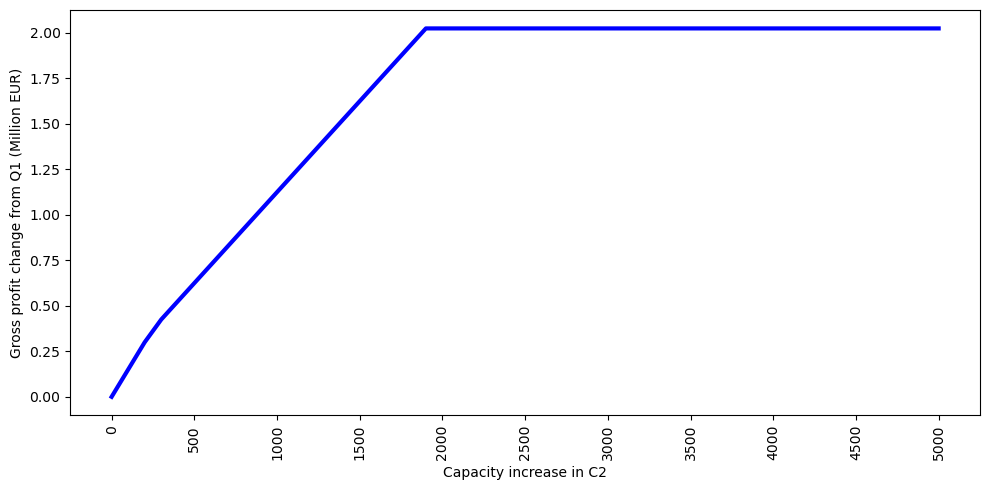

In [ ]:
#@title The code below allows you to visualize how the **profit change** depends on the **capacity increase** in a facility

#@markdown Select one of the facilities
facility = 'C2' #@param ["Zuffe", "Leip", "C1", "C2", "C3"] {allow-input: false}

# set up values for the capacity increase
step = 100
max_increase = 5000
cap_increase = list(np.arange(0,max_increase+step,step))

# the objective values and the loss compared to Q1
objValues = [0]*len(cap_increase)
change_Q1 = [0]*len(cap_increase)

# Create a model like the one in Q1
m_Q6, factoriesToCenters, centersToRetailers, retailerReceipts, gross_profit, constr = \
       create_model_like_in_Q1()

m_Q6.setParam('OutputFlag', 0)   # supress Gurobi's output

for i in range(len(cap_increase)):

    # change capacity at the facility
    if facility in factories:
        constr["factory_cap"][facility].setAttr('rhs', factoriesDF["Capacity"][facility] + cap_increase[i])

    elif facility in centers:
        constr["center_cap"][facility].setAttr('rhs', customizationCentersDF["Capacity"][facility] + cap_increase[i])

    # solve the model
    m_Q6.optimize()

    #print("{:10.2f} : {:10.2f} ".format(cap_increase[i],center_cap_constraints["C1"].pi))

    objValues[i] = m_Q6.objVal
    #change_Q1[i] = (objValues[i]/gross_profit_Q1 - 1.0)*100
    change_Q1[i] = (objValues[i] - gross_profit_Q1)/1e6

#@markdown Visualize the dependency
# first set of settings are useful for Powerpoint
#fontsize = 20
#fig, ax1 = plt.subplots(figsize=(18,8))
fontsize = 10
fig, ax1 = plt.subplots(figsize=(10,5))

# plot the gross profits changes
plt.plot(cap_increase, change_Q1, linestyle='solid', linewidth=3, color='blue')

plt.xlabel("Capacity increase in " + facility, fontsize=fontsize)
plt.ylabel("Gross profit change from Q1 (Million EUR)", fontsize=fontsize)
plt.yticks(fontsize=fontsize)

mark_every = 5
plt.xticks(ticks=cap_increase[0:len(cap_increase):mark_every], rotation=90)
plt.xticks(fontsize=fontsize)

# calculate the required payments
#plt.legend(("Gross profit change from Q1","Payments for new capacity"),fontsize=30,loc="lower center")
plt.tight_layout()
plt.show()

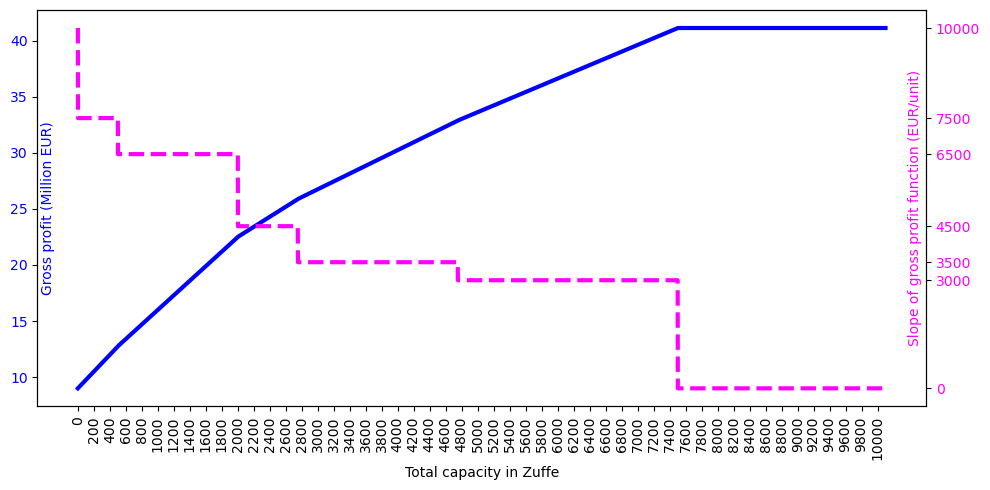

In [ ]:
#@title The code below allows you to visualize how the **gross profit** depends on the **total installed capacity** in a facility

#@markdown Select one of the facilities
facility = 'Zuffe' #@param ["Zuffe", "Leip", "C1", "C2", "C3"] {allow-input: false}

# set up values for the capacity increase
cap_values = list(np.arange(0,10100,1))

# the objective values and the loss compared to Q1
objValues = [0]*len(cap_values)
#change_Q1 = [0]*len(cap_values)
shadow_prices = [0]*len(cap_values)

# Create a model like the one in Q1
m_Q6, factoriesToCenters, centersToRetailers, retailerReceipts, gross_profit, constr = \
       create_model_like_in_Q1()

m_Q6.setParam('OutputFlag', 0)   # supress Gurobi's output

for i in range(len(cap_values)):

    # change capacity at the facility
    if facility in factories:
        con_changing = constr["factory_cap"][facility]

    elif facility in centers:
        con_changing = constr["center_cap"][facility]

    con_changing.setAttr('rhs', cap_values[i])


    # solve the model
    m_Q6.optimize()

    #print("{:10.2f} : {:10.2f} ".format(cap_increase[i],center_cap_constraints["C1"].pi))

    objValues[i] = m_Q6.objVal/1e6
    #change_Q1[i] = (objValues[i]/gross_profit_Q1 - 1.0)*100
    #change_Q1[i] = (objValues[i] - gross_profit_Q1)/1e6

    # store the shadow price
    shadow_prices[i] = con_changing.Pi

#@markdown Visualize the dependency
# first set of settings are useful for Powerpoint
#fontsize = 20
#fig, ax1 = plt.subplots(figsize=(20,10))
fontsize = 10
fig, ax1 = plt.subplots(figsize=(10,5))

# plot the gross profits changes
color1 = 'blue'
plt.plot(cap_values, objValues, linestyle='solid', linewidth=3, color=color1)

plt.xlabel("Total capacity in " + facility, fontsize=fontsize)
plt.ylabel("Gross profit (Million EUR)", fontsize=fontsize, color=color1)
ax1.yaxis.set_label_coords(0.02,0.5)
ax1.tick_params(axis='y', labelcolor=color1)
plt.yticks(fontsize=fontsize)

mark_every = 200
plt.xticks(ticks=cap_values[0:len(cap_values):mark_every], rotation=90)
plt.xticks(fontsize=fontsize)

show_shadow_prices = True

if show_shadow_prices:
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color2 = 'magenta'
    ax2.set_ylabel('Slope of gross profit function (EUR/unit)', color=color2, fontsize=fontsize)  # we already handled the x-label with ax1
    ax2.yaxis.set_label_coords(0.98,0.5)
    ax2.plot(cap_values, shadow_prices, color='magenta', linestyle='--', linewidth=3)
    ax2.tick_params(axis='y', labelcolor=color2)
    plt.yticks(ticks=np.unique(shadow_prices), fontsize=fontsize)
    plt.xticks(fontsize=fontsize)

plt.tight_layout()
plt.show()

## Q7 - flexibility

Average gross profit without flexibility/postponement: 32,238,475 EUR
Average profit: 33,652,124 EUR


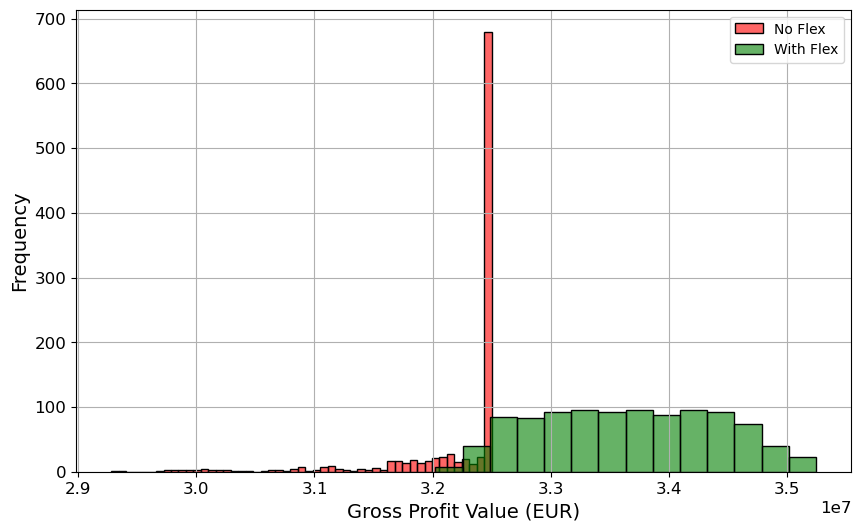

In [ ]:
# secondary price
price_separate_channel = 65000

# range of variability for pre-orders (as percent nominal)
range_orders = 0.5

# set up a random number generator with seed 12345
rng = np.random.default_rng(seed=12345)
num_trials = 1000

# numeric index for each scenario
scenarios = range(0,num_trials)

# generate the actual demand values
retailer_true_demand = {}
for r in retailers:
   pre_orders = retailersDF.loc[r,"Pre-orders"]
   delta = np.floor(pre_orders * range_orders)
   retailer_true_demand[r] = rng.integers(pre_orders-delta, pre_orders+delta+1, \
                                          size=num_trials)


##########################################
# STATIC MODEL - ALL PRODUCTION DECISIONS BEFORE KNOWING THE TRUE RETAILER DEMAND

# empty Gurobi model
m_Q7a = Model("Prosche Motors Uncertainty")

# Decision variables
# decision variables for how much to ship from each factory to each customization center
factoriesToCenters_Q7a = m_Q7a.addVars( factories, centers , name = "Ship")

# decision variables for how much to ship from each customization center to each client
centersToRetailers_Q7a = m_Q7a.addVars( centers, retailers , name="Ship")

# how many ACTUAL sales are done at each retailer (this is now scenario-dependent)
actual_sales_Q7a = m_Q7a.addVars(scenarios, retailers, name="Filled")

# calculate how much each retailer is sent
retailerReceipts_Q7a = {}
for r in retailers:
    retailerReceipts_Q7a[r] = quicksum( centersToRetailers_Q7a[c,r] for c in centers )

# REVENUES DEPEND ON WHAT IS ACTUALLY SOLD AT THE RETAILERS + THE SECONDARY CHANNEL
# calculate average revenues
avg_revenues_Q7a = quicksum( actual_sales_Q7a[s,r] * retailersDF.loc[r,"Price"] + \
                            (retailerReceipts_Q7a[r]-actual_sales_Q7a[s,r])*price_separate_channel \
                            for s in scenarios for r in retailers ) / num_trials

#### COSTS
# there are three terms known ahead:
# - production costs (at factories)
prodCost_Q7a = quicksum( factoriesToCenters_Q7a[f,c] * factoriesDF.loc[f,"Cost"]\
                    for f in factories for c in centers )

# - handling & transportation costs factories to customization centers
transCost_FC_Q7a = quicksum( factoriesToCenters_Q7a[f,c] * \
                        costsFactoriesToCentersDF.loc[f,c] for f in factories for c in centers )

# - customization cost (incurred at the customization centers)
customizationCost_Q7a = quicksum( centersToRetailers_Q7a[c,r] * \
                              customizationCentersDF.loc[c,"Staffing_Cost"] \
                              for c in centers for r in retailers )

# - transportation costs customization centers to retail stores
transCost_CR_Q7a = quicksum( centersToRetailers_Q7a[c,r] * \
                        costsCentersToRetailersDF.loc[c,r] for c in centers for r in retailers )

# total costs
totalCost_Q7a =  prodCost_Q7a + transCost_FC_Q7a + customizationCost_Q7a + transCost_CR_Q7a

# GROSS PROFIT DEPENDS ON SCENARIO
# calculate average gross profit
avg_gross_profit_Q7a = avg_revenues_Q7a - totalCost_Q7a

# set the objective: maximize gross profit
m_Q7a.setObjective( avg_gross_profit_Q7a, GRB.MAXIMIZE )

# Constraints
constraints_Q7a = {}  # will store all the constraints

# capacity constraints due to production at each factory
constraints_Q7a["factory_cap"] = {}
for f in factories :
    constraints_Q7a["factory_cap"][f] = \
    m_Q7a.addConstr( quicksum(factoriesToCenters_Q7a[f,c] for c in centers) \
                <= factoriesDF.loc[f,"Capacity"], name = "Cap_" + f)

# capacity constraints at customization centers
constraints_Q7a["center_cap"] = {}
for c in centers :
    constraints_Q7a["center_cap"][c] = \
    m_Q7a.addConstr( quicksum(centersToRetailers_Q7a[c,r] for r in retailers) \
                <= customizationCentersDF.loc[c,"Capacity"], name = "Cap_" + c)

# flow conservation at each customization center: cars going in = cars going out
for c in centers :
    m_Q7a.addConstr( quicksum(factoriesToCenters_Q7a[f,c] for f in factories) == \
                        quicksum(centersToRetailers_Q7a[c,r] for r in retailers), name = "Flow_cons_" + c )

# constraints on SALES -- THESE ARE NOW SCENARIO DEPENDENT
constraints_Q7a["sales_cap"] = {}
for s in scenarios:
    for r in retailers :
        # cannot fill more than realized demand
        m_Q7a.addConstr(actual_sales_Q7a[s,r] <= retailer_true_demand[r][s], name=f"TrueDem_{r}_{s}")

        # cannot fill more than what was sent
        m_Q7a.addConstr(actual_sales_Q7a[s,r] <= retailerReceipts_Q7a[r], name=f"SentCars_{r}_{s}")

# # return the model, the decision variables and the formula for the objective
# return m, factoriesToCenters, centersToRetailers, gross_profit,\
# constraints

m_Q7a.setParam('OutputFlag', 0)   # supress Gurobi's output
m_Q7a.optimize()

# calculate revenue and profits in each scenario, so that we can also do a histogram
profit_by_scenario_Q7a = np.zeros(num_trials)
for s in scenarios:
    profit_by_scenario_Q7a[s] = sum( (actual_sales_Q7a[s,r].X * retailersDF.loc[r,"Price"] + \
                                    (retailerReceipts_Q7a[r].getValue() - actual_sales_Q7a[s,r].X)*\
                                    price_separate_channel) for r in retailers) - totalCost_Q7a.getValue()

# print average profit
print(f"Average gross profit without flexibility/postponement: {m_Q7a.objVal:,.0f} EUR")

##########################################
# DYNAMIC MODEL - ALL PRODUCTION DECISIONS AFTER KNOWING THE TRUE RETAILER DEMAND
profit_by_scenario_Q7b = np.zeros(num_trials)

for s in scenarios:
    #
    demand_dict = {}
    for r in retailers:
        demand_dict[r] = retailer_true_demand[r][s]

    m_Q7b, factoriesToCenters_Q7b, centersToRetailers_Q7b, retailerReceipts_Q7b, gross_profit_Q7b, constr_Q7b = \
       create_model_like_in_Q1(use_custom_demands=True, custom_demand_dict=demand_dict)

    m_Q7b.setParam("OutputFlag",0)
    m_Q7b.optimize()

    profit_by_scenario_Q7b[s] = m_Q7b.objVal

# print average profit:
print(f"Average profit: {np.mean(profit_by_scenario_Q7b):,.0f} EUR")

##########################################
# Create dual histogram and print average profits
f = plt.figure(figsize=(10, 6))
ax = f.gca()

# Plot histograms
#ax.hist(profit_by_scenario_Q7a, bins=30, alpha=0.5, label='Without flexibility/postponement', color='blue')
#ax.hist(profit_by_scenario_Q7b, bins=30, alpha=0.5, label='With flexibility', color='red')

sns.histplot(profit_by_scenario_Q7a, color="red", kde=False, alpha=0.6, label="No Flex")
sns.histplot(profit_by_scenario_Q7b, color="green", kde=False, alpha=0.6, label="With Flex")

# Style and settings
ax.set_xlabel('Gross Profit Value (EUR)')
ax.set_ylabel('Frequency')
#ax.set_title('Histogram Comparing The Cases With / Without Flexibility')
ax.grid(True)
ax.legend()

# Display the plot
plt.show()

## Create data files
This section of code runs through multiple values of the variability parameter, creates a dataframe to store all the results, and then writes everything to files.

In [ ]:
# a function that basically runs the code above -- both STATIC and DYNAMIC case -- for a given variability
def run_flex_no_flex(variability_param, num_trials):
    # variability_parameter 'rho' takes values from 0 to 1
    # the actual orders will be uniformly distributed between [ (1-rho)*pre-orders, (1+rho)*pre-orders ]

    # set up a random number generator with seed 12345
    rng = np.random.default_rng(seed=12345)

    # numeric index for each scenario
    scenarios = range(0,num_trials)

    # generate the actual demand values
    retailer_true_demand = {}
    for r in retailers:
       pre_orders = retailersDF.loc[r,"Pre-orders"]
       delta = np.floor(pre_orders * variability_param)
       retailer_true_demand[r] = rng.integers(pre_orders-delta, pre_orders+delta+1, \
                                              size=num_trials)

    ##########################################
    # STATIC MODEL - ALL PRODUCTION DECISIONS BEFORE KNOWING THE TRUE RETAILER DEMAND

    # empty Gurobi model
    m_Q7a = Model("Prosche Motors Uncertainty")

    # Decision variables
    # decision variables for how much to ship from each factory to each customization center
    factoriesToCenters_Q7a = m_Q7a.addVars( factories, centers , name = "Ship")

    # decision variables for how much to ship from each customization center to each client
    centersToRetailers_Q7a = m_Q7a.addVars( centers, retailers , name="Ship")

    # how many ACTUAL sales are done at each retailer (this is now scenario-dependent)
    actual_sales_Q7a = m_Q7a.addVars(scenarios, retailers, name="Filled")

    # calculate how much each retailer is sent
    retailerReceipts_Q7a = {}
    for r in retailers:
        retailerReceipts_Q7a[r] = quicksum( centersToRetailers_Q7a[c,r] for c in centers )

    # REVENUES DEPEND ON WHAT IS ACTUALLY SOLD AT THE RETAILERS + THE SECONDARY CHANNEL
    # calculate average revenues
    avg_revenues_Q7a = quicksum( actual_sales_Q7a[s,r] * retailersDF.loc[r,"Price"] + \
                                (retailerReceipts_Q7a[r]-actual_sales_Q7a[s,r])*price_separate_channel \
                                for s in scenarios for r in retailers ) / num_trials

    #### COSTS
    # there are three terms known ahead:
    # - production costs (at factories)
    prodCost_Q7a = quicksum( factoriesToCenters_Q7a[f,c] * factoriesDF.loc[f,"Cost"]\
                        for f in factories for c in centers )

    # - handling & transportation costs factories to customization centers
    transCost_FC_Q7a = quicksum( factoriesToCenters_Q7a[f,c] * \
                            costsFactoriesToCentersDF.loc[f,c] for f in factories for c in centers )

    # - customization cost (incurred at the customization centers)
    customizationCost_Q7a = quicksum( centersToRetailers_Q7a[c,r] * \
                                  customizationCentersDF.loc[c,"Staffing_Cost"] \
                                  for c in centers for r in retailers )

    # - transportation costs customization centers to retail stores
    transCost_CR_Q7a = quicksum( centersToRetailers_Q7a[c,r] * \
                            costsCentersToRetailersDF.loc[c,r] for c in centers for r in retailers )

    # total costs
    totalCost_Q7a =  prodCost_Q7a + transCost_FC_Q7a + customizationCost_Q7a + transCost_CR_Q7a

    # GROSS PROFIT DEPENDS ON SCENARIO
    # calculate average gross profit
    avg_gross_profit_Q7a = avg_revenues_Q7a - totalCost_Q7a

    # set the objective: maximize gross profit
    m_Q7a.setObjective( avg_gross_profit_Q7a, GRB.MAXIMIZE )

    # Constraints
    constraints_Q7a = {}  # will store all the constraints

    # capacity constraints due to production at each factory
    constraints_Q7a["factory_cap"] = {}
    for f in factories :
        constraints_Q7a["factory_cap"][f] = \
        m_Q7a.addConstr( quicksum(factoriesToCenters_Q7a[f,c] for c in centers) \
                    <= factoriesDF.loc[f,"Capacity"], name = "Cap_" + f)

    # capacity constraints at customization centers
    constraints_Q7a["center_cap"] = {}
    for c in centers :
        constraints_Q7a["center_cap"][c] = \
        m_Q7a.addConstr( quicksum(centersToRetailers_Q7a[c,r] for r in retailers) \
                    <= customizationCentersDF.loc[c,"Capacity"], name = "Cap_" + c)

    # flow conservation at each customization center: cars going in = cars going out
    for c in centers :
        m_Q7a.addConstr( quicksum(factoriesToCenters_Q7a[f,c] for f in factories) == \
                            quicksum(centersToRetailers_Q7a[c,r] for r in retailers), name = "Flow_cons_" + c )

    # constraints on SALES -- THESE ARE NOW SCENARIO DEPENDENT
    constraints_Q7a["sales_cap"] = {}
    for s in scenarios:
        for r in retailers :
            # cannot fill more than realized demand
            m_Q7a.addConstr(actual_sales_Q7a[s,r] <= retailer_true_demand[r][s], name=f"TrueDem_{r}_{s}")

            # cannot fill more than what was sent
            m_Q7a.addConstr(actual_sales_Q7a[s,r] <= retailerReceipts_Q7a[r], name=f"SentCars_{r}_{s}")

    # # return the model, the decision variables and the formula for the objective
    # return m, factoriesToCenters, centersToRetailers, gross_profit,\
    # constraints

    m_Q7a.setParam('OutputFlag', 0)   # supress Gurobi's output
    m_Q7a.optimize()

    # calculate shipments and sales by retailer, in each scenario
    shipments_Q7a = {}
    sales_Q7a = {}
    for r in retailers:
        # the amount shipped does NOT depend on scenario
        shipments_Q7a[r] = np.zeros(num_trials) + retailerReceipts_Q7a[r].getValue()

        # the sales DO depend on scenario
        sales_Q7a[r] = [actual_sales_Q7a[s,r].X for s in scenarios]

    # calculate gross profits by scenario
    total_costs_Q7a = totalCost_Q7a.getValue()
    profits_Q7a = [ (sum( (sales_Q7a[r][s]*retailersDF.loc[r,"Price"] + \
                           (shipments_Q7a[r][s] - sales_Q7a[r][s])*price_separate_channel)\
                         for r in retailers) - total_costs_Q7a) for s in scenarios ]

    # print average profit
    print(f"rho={variability_param:.2f} {'without flexibility':<20s} : {m_Q7a.objVal:,.0f} EUR")

    ##########################################
    # DYNAMIC MODEL - ALL PRODUCTION DECISIONS AFTER KNOWING THE TRUE RETAILER DEMAND
    profits_Q7b = np.zeros(num_trials)
    shipments_Q7b = {}
    sales_Q7b = {}
    for r in retailers:
        shipments_Q7b[r] = np.zeros(num_trials)
        sales_Q7b[r] = np.zeros(num_trials)

    for s in scenarios:
        # create a dictionary with the demand values, to use in the function
        demand_dict = {}
        for r in retailers:
            demand_dict[r] = retailer_true_demand[r][s]

        m_Q7b, factoriesToCenters_Q7b, centersToRetailers_Q7b, retailerReceipts_Q7b, gross_profit_Q7b, constr_Q7b = \
           create_model_like_in_Q1(use_custom_demands=True, custom_demand_dict=demand_dict)

        m_Q7b.setParam("OutputFlag",0)
        m_Q7b.optimize()

        # store gross profits
        profits_Q7b[s] = m_Q7b.objVal

        # calculate shipments and sales by retailer, in each scenario
        for r in retailers:
            # the amount shipped does NOT depend on scenario
            shipments_Q7b[r][s] = retailerReceipts_Q7b[r].getValue()

            # the sales DO depend on scenario
            sales_Q7b[r][s] = retailerReceipts_Q7b[r].getValue()

    # print average profit:
    print(f"rho={variability_param:.2f} {'with flexibility':<20s} : {m_Q7b.objVal:,.0f} EUR")

    # return the two profit vectors (for now)
    return profits_Q7a, shipments_Q7a, sales_Q7a, profits_Q7b, shipments_Q7b, sales_Q7b

### Create the datasets by solving the optimization problems
Solve opt problems at different levels of uncertainty and save the resoluts to files.

In [ ]:
# number of trials
num_trials = 10000

# numeric index for each scenario
scenarios = range(0,num_trials)

# values for the variability parameter
variability_param_values = np.arange(0.0, 1.05, 0.05)

### create a single dataframe
# one row per scenario, several columns, as follows:
# for profits, two columns for each value of the range parameter (for STATIC / DYNAMIC)
# for shipments: two columns for every retailer, and for each value of the range parameter
# for sales: two columns for every retailer, and for each value of the range parameter

df_results = pd.DataFrame(index=scenarios)

### for every value of the variability parameter:
# compute static & dynamic solutions and store profit/shipments/sales realizations by scenario
for variability_param in variability_param_values:
    profits_sta, shipments_sta, sales_sta, \
    profits_dyn, shipments_dyn, sales_dyn = run_flex_no_flex(variability_param, num_trials)

    # store the profits
    df_results[f"profits_static_{variability_param:.2f}"] = profits_sta
    df_results[f"profits_dynamic_{variability_param:.2f}"] = profits_dyn

    # store the shipments for each retailer
    for r in retailers:
        df_results[f"shipments_static_{r}_{variability_param:.2f}"] = shipments_sta[r]
        df_results[f"shipments_dynamic_{r}_{variability_param:.2f}"] = shipments_dyn[r]

    # store the sales for each retailer
    for r in retailers:
        df_results[f"sales_static_{r}_{variability_param:.2f}"] = sales_sta[r]
        df_results[f"sales_dynamic_{r}_{variability_param:.2f}"] = sales_dyn[r]

### save the dataframe to a file
df_results.to_csv("results_static_dynamic.csv", sep=',', index=True)

rho=0.00 without flexibility  : 33,625,000 EUR
rho=0.00 with flexibility     : 33,625,000 EUR
rho=0.05 without flexibility  : 33,482,419 EUR
rho=0.05 with flexibility     : 33,639,500 EUR
rho=0.10 without flexibility  : 33,339,702 EUR
rho=0.10 with flexibility     : 33,653,000 EUR
rho=0.15 without flexibility  : 33,198,128 EUR
rho=0.15 with flexibility     : 33,667,500 EUR
rho=0.20 without flexibility  : 33,055,421 EUR
rho=0.20 with flexibility     : 33,682,000 EUR
rho=0.25 without flexibility  : 32,913,835 EUR
rho=0.25 with flexibility     : 33,694,000 EUR
rho=0.30 without flexibility  : 32,771,123 EUR
rho=0.30 with flexibility     : 33,708,500 EUR
rho=0.35 without flexibility  : 32,629,532 EUR
rho=0.35 with flexibility     : 33,723,000 EUR
rho=0.40 without flexibility  : 32,486,848 EUR
rho=0.40 with flexibility     : 33,736,500 EUR
rho=0.45 without flexibility  : 32,345,274 EUR
rho=0.45 with flexibility     : 33,751,000 EUR
rho=0.50 without flexibility  : 32,202,560 EUR
rho=0.50 with

## Read the file and plot various things


### Comparing static solutions for different levels of variability

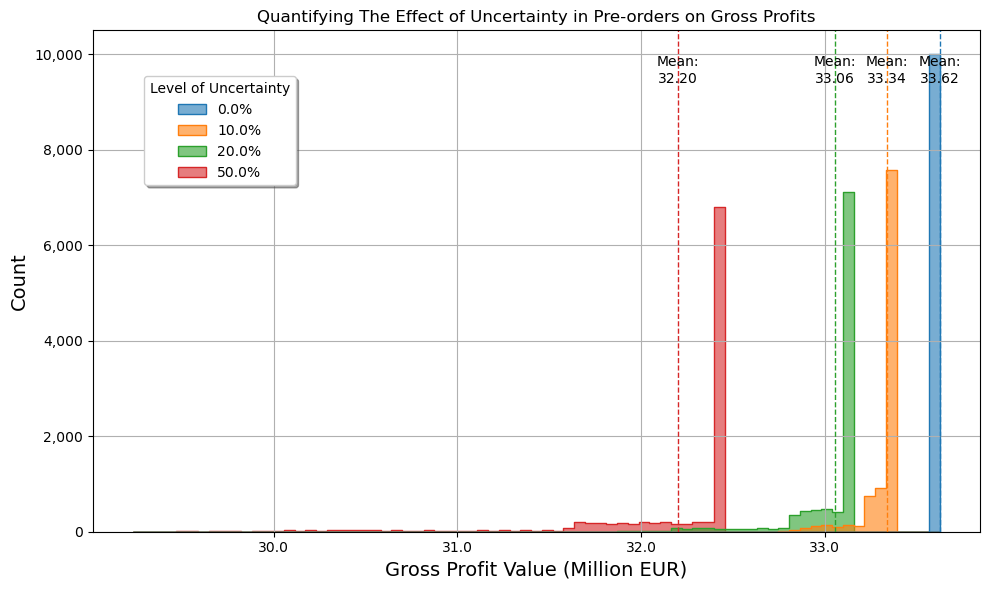

In [ ]:
### create a single dataframe
# one row per scenario, two columns for each value of the range parameter (for STATIC/no-flex and DYNAMIC/flex)
filename = "results_static_dynamic.csv"
df_results = pd.read_csv(filename)

param_values_to_compare = ["0.00", "0.10", "0.20", "0.50"]

all_cols_static = [f"profits_static_{rho}" for rho in param_values_to_compare]

font_size = 12.0
font_size_ticks = 10.0

# Assuming df_results, all_cols_static, and all_labels are defined
melted_df = pd.melt(df_results, value_vars=all_cols_static, var_name='Uncertainty', value_name='Gross Profit Value')
melted_df['Gross Profit Value'] /= 1e+6

### CREATE THE FIGURE
palette_choice = 'tab10'
plt.figure(figsize=(10, 6))
sns.histplot(data=melted_df, x='Gross Profit Value', hue='Uncertainty', stat="count", kde=False, \
             alpha=0.6, element='step', palette=palette_choice)

plt.xlabel('Gross Profit Value (Million EUR)')
plt.ylabel('Count')
plt.title('Quantifying The Effect of Uncertainty in Pre-orders on Gross Profits')
plt.grid(True)

# Adjust tick formatting as needed
ax = plt.gca()
ax.tick_params(axis='x', labelsize=font_size_ticks)
ax.tick_params(axis='y', labelsize=font_size_ticks)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}'))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Update the legend to show proper formatting for the percentages
legend = ax.get_legend()
if legend:
    # set a title
    legend.set_title("Level of Uncertainty")

    # format the labels for the legend
    new_labels = [f"{float(label.get_text()[-4:])*100:.1f}%" for label in legend.get_texts()]

    # update the labels
    for text, new_label in zip(legend.get_texts(), new_labels):
        text.set_text(new_label)

# move the legend
sns.move_legend(ax, "center left", bbox_to_anchor=(0.05, 0.8), ncol=1, fancybox=True, shadow=True)

# Calculate means and plot vertical lines
palette = sns.color_palette(palette_choice)

for i, group in enumerate(all_cols_static):
    mean_value = df_results[group].mean()/1e6   # express the mean in millions

    # Plot vertical line for the mean
#     plt.axvline(x=mean_value, color=palette[i], linestyle='--', linewidth=1, \
#                 label=f'{group}: {mean_value:.2f} Million EUR')

    plt.axvline(x=mean_value, color=palette[i], linestyle='--', linewidth=1)
    plt.text(mean_value, ax.get_ylim()[1]*0.95, f'Mean:\n{mean_value:.2f}', color='black', \
             ha='center', va='top')

plt.tight_layout()
plt.show()

### Comparing static solutions with dynamic solutions at a given variability level

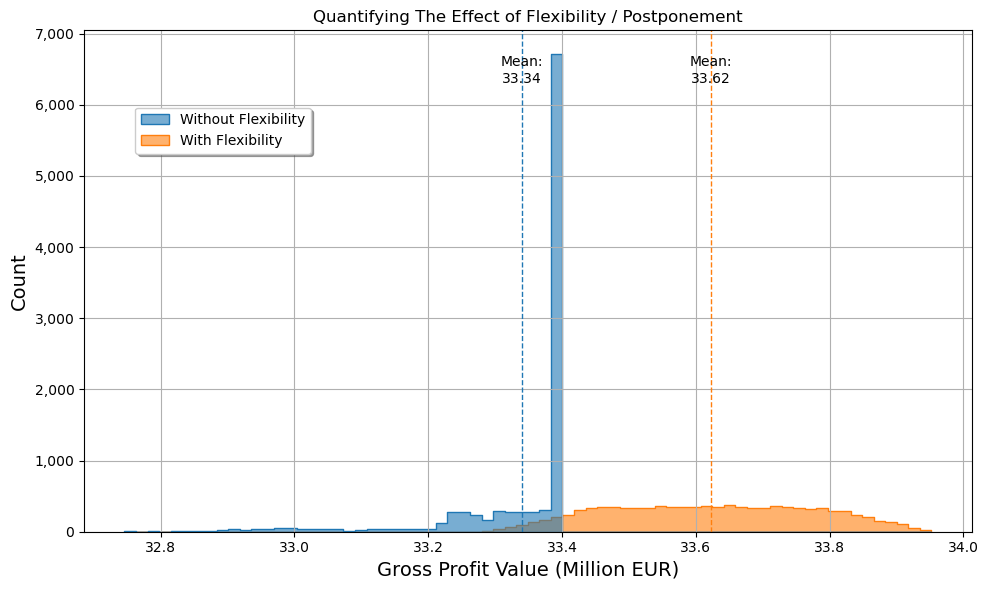

In [ ]:
### create a single dataframe
# one row per scenario, two columns for each value of the range parameter (for STATIC/no-flex and DYNAMIC/flex)
filename = "results_static_dynamic.csv"
df_results = pd.read_csv(filename)

variability_level = ["0.10"]

all_cols = [f"profits_static_{rho}" for rho in variability_level] + \
     [f"profits_dynamic_{rho}" for rho in variability_level]

font_size = 12.0
font_size_ticks = 10.0

# Assuming df_results, all_cols_static, and all_labels are defined
melted_df = pd.melt(df_results, value_vars=all_cols, var_name='Type', value_name='Gross Profit Value')
melted_df['Gross Profit Value'] /= 1e+6

### CREATE THE FIGURE
palette_choice = 'tab10'
plt.figure(figsize=(10, 6))
sns.histplot(data=melted_df, x='Gross Profit Value', hue='Type', stat="count", kde=False, \
             alpha=0.6, element='step', palette=palette_choice)

plt.xlabel('Gross Profit Value (Million EUR)')
plt.ylabel('Count')
plt.title('Quantifying The Effect of Flexibility / Postponement')
plt.grid(True)

# Adjust tick formatting as needed
ax = plt.gca()
ax.tick_params(axis='x', labelsize=font_size_ticks)
ax.tick_params(axis='y', labelsize=font_size_ticks)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}'))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Update the legend to show proper formatting for the percentages
legend = ax.get_legend()
if legend:
    ### get the original labels
    old_labels = [label.get_text() for label in legend.get_texts()]

    ### format them:
    # if there is a single uncertainty level, don't include it in the label
    if len(variability_level)==1:
        new_labels = [("Without Flexibility" if "static" in label else "With Flexibility") \
                      for label in old_labels]
    else:
        # include the uncertainty level in the label as well
        # format the labels for the legend
        new_labels = [f"{'Without Flexibility' if 'static' in label else 'With Flexibility'} ({float(label[-4:])*100:.1f}%)"
                      for label in old_labels]

    legend.set_title("")

    # set the new labels
    for text, new_label in zip(legend.get_texts(), new_labels):
        text.set_text(new_label)


# move the legend
sns.move_legend(ax, "center left", bbox_to_anchor=(0.05, 0.8), ncol=1, fancybox=True, shadow=True)

# Calculate means and plot vertical lines
palette = sns.color_palette(palette_choice)

for i, group in enumerate(all_cols):
    mean_value = df_results[group].mean()/1e6   # express the mean in millions

    plt.axvline(x=mean_value, color=palette[i], linestyle='--', linewidth=1)
    plt.text(mean_value, ax.get_ylim()[1]*0.95, f'Mean:\n{mean_value:.2f}', color='black', \
             ha='center', va='top')

plt.tight_layout()
plt.show()

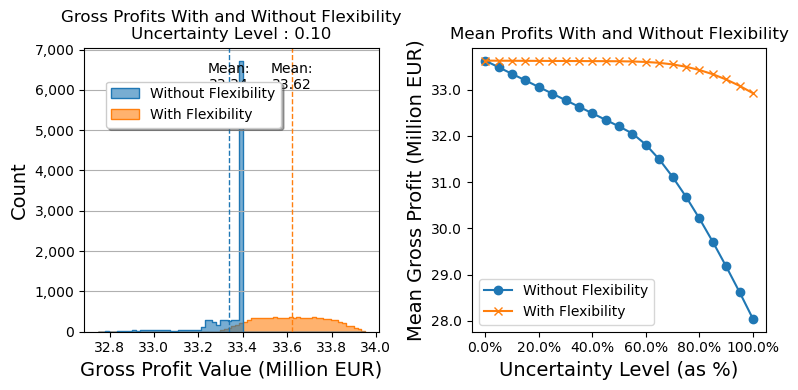

In [ ]:
### create a single dataframe
# one row per scenario, two columns for each value of the range parameter (for STATIC/no-flex and DYNAMIC/flex)
variability_level = ["0.10"]

compare_the_means = True

# read the relevant results from a file
filename = "results_static_dynamic.csv"
df_results = pd.read_csv(filename)

# some adjustable params
font_size = 12.0
font_size_ticks = 10.0
fig_width = 8
fig_height = 4

nfigs = (2 if compare_the_means else 1)

# Create a figure with two subplots
fig, axs = plt.subplots(1, nfigs, figsize=(fig_width, fig_height))  # Adjust the size as needed

# if nfigs > 1:
#     fig.suptitle('Quantifying The Effect of Flexibility / Postponement')

###### FIRST PLOT: histograms at specific uncertainty level

# create the list with the necessary columns
all_cols = [f"profits_static_{rho}" for rho in variability_level] + \
     [f"profits_dynamic_{rho}" for rho in variability_level]

# Assuming df_results, all_cols_static, and all_labels are defined
melted_df = pd.melt(df_results, value_vars=all_cols, var_name='Type', value_name='Gross Profit Value')
melted_df['Gross Profit Value'] /= 1e+6

############# CREATE THE FIGURE
palette_choice = 'tab10'

# fix the axes choice (subplots returns a scalar if there's a single plot!)
if nfigs > 1:
    ax1 = axs[0]
else:
    ax1 = axs

sns.histplot(data=melted_df, x='Gross Profit Value', hue='Type', stat="count", kde=False, \
             alpha=0.6, element='step', palette=palette_choice, ax=ax1)

ax1.set_title(f"Gross Profits With and Without Flexibility\nUncertainty Level : {variability_level[0]}")
ax1.set_xlabel('Gross Profit Value (Million EUR)')
ax1.set_ylabel('Count')

# Adjust tick formatting and grids as needed
ax1.tick_params(axis='x', labelsize=font_size_ticks)
ax1.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}'))
ax1.xaxis.grid(False)

ax1.tick_params(axis='y', labelsize=font_size_ticks)
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax1.yaxis.grid(True)

# Update the legend to show proper formatting for the percentages
legend = ax1.get_legend()
legend.set_title("")
if legend:
    ### get the original labels
    old_labels = [label.get_text() for label in legend.get_texts()]

    ### format them:
    # if there is a single uncertainty level, don't include it in the label
    if len(variability_level)==1:
        new_labels = [("Without Flexibility" if "static" in label else "With Flexibility") \
                      for label in old_labels]
    else:
        # include the uncertainty level in the label as well
        # format the labels for the legend
        new_labels = [f"{'Without Flexibility' if 'static' in label else 'With Flexibility'} ({float(label[-4:])*100:.1f}%)"
                      for label in old_labels]

    # set the new labels
    for text, new_label in zip(legend.get_texts(), new_labels):
        text.set_text(new_label)

# move the legend
sns.move_legend(ax1, "center left", bbox_to_anchor=(0.05, 0.8), ncol=1, fancybox=True, shadow=True)

# Calculate means and plot vertical lines
palette = sns.color_palette(palette_choice)

for i, group in enumerate(all_cols):
    mean_value = df_results[group].mean()/1e6   # express the mean in millions

    ax1.axvline(x=mean_value, color=palette[i], linestyle='--', linewidth=1)
    ax1.text(mean_value, ax1.get_ylim()[1]*0.95, f'Mean:\n{mean_value:.2f}', color='black', \
             ha='center', va='top')

############# SECOND FIGURE (IF NEEDED)
if compare_the_means:

    # get all the uncertainty values in the dataframe
    all_uncertainty_values = np.sort([float(col[-4:]) for col in df_results.columns if "profits_static" in col ])

    means_static = [df_results[f"{'profits_static'}_{rho:.2f}"].mean()/1e6 for rho in all_uncertainty_values ]
    means_dynamic = [df_results[f"{'profits_dynamic'}_{rho:.2f}"].mean()/1e6 for rho in all_uncertainty_values ]

    # Plotting the means for list1
    axs[1].plot(all_uncertainty_values*100, means_static, label='Without Flexibility', marker='o')  # Add markers for clarity

    # Plotting the means for list2 on the same subplot
    axs[1].plot(all_uncertainty_values*100, means_dynamic, label='With Flexibility', marker='x')  # Different marker for distinction

    # Customize the subplot
    axs[1].set_title('Mean Profits With and Without Flexibility')
    axs[1].set_xlabel('Uncertainty Level (as %)')
    axs[1].set_ylabel('Mean Gross Profit (Million EUR)')
    axs[1].legend()

    axs[1].set_xticklabels(all_uncertainty_values*100)
    axs[1].tick_params(axis='x', labelsize=font_size_ticks)
    axs[1].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}%'))
    axs[1].tick_params(axis='y', labelsize=font_size_ticks)
    axs[1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}'))

plt.tight_layout()
plt.show()